# Спортивный анализ данных. Платформа Kaggle. Курсовой проект

## Загрузка данных и поключение библиотек

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle competitions download -c geekbrains-competitive-data-analysis

 81% 17.0M/21.0M [00:00<00:00, 32.2MB/s]
100% 21.0M/21.0M [00:00<00:00, 38.1MB/s]
  0% 0.00/586k [00:00<?, ?B/s]
100% 586k/586k [00:00<00:00, 122MB/s]
  0% 0.00/632k [00:00<?, ?B/s]
100% 632k/632k [00:00<00:00, 129MB/s]
 36% 9.00M/25.2M [00:00<00:00, 45.0MB/s]
100% 25.2M/25.2M [00:00<00:00, 81.1MB/s]
 43% 5.00M/11.7M [00:00<00:00, 40.2MB/s]
100% 11.7M/11.7M [00:00<00:00, 55.7MB/s]
  0% 0.00/434k [00:00<?, ?B/s]
100% 434k/434k [00:00<00:00, 94.5MB/s]
 88% 53.0M/59.9M [00:01<00:00, 33.5MB/s]
100% 59.9M/59.9M [00:01<00:00, 45.1MB/s]


In [ ]:
!pip install catboost
!pip install eli5
!pip install shap
!unzip /content/applications_history.csv.zip
!unzip /content/bki.csv.zip
!unzip /content/client_profile.csv.zip
!unzip /content/payments.csv.zip
!unzip /content/sample_submit.csv.zipa
!unzip /content/test.csv.zip
!unzip /content/train.csv.zip

     |████████████████████████████████| 67.3MB 58kB/s 
     |████████████████████████████████| 112kB 5.4MB/s 
     |████████████████████████████████| 358kB 5.0MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491616 sha256=2c0cfb44938c46b37a7d879919c010c44730c8990978b5f28b472285bdd7e3e5
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
Archive:  /content/applications_history.csv.zip
  inflating: applications_history.csv  
Archive:  /content/bki.csv.zip
  inflating: bki.csv                 
Archive:  /content/client_profile.csv.zip
  inflating: client_profile.csv      
Archive:  /content/payments.csv.zip
  inflating: payments.csv            
unzip:  cannot find or open /content/sample_submit.csv.zipa, /content/sample_submit.csv.zipa.zip or /content/sample_submit.csv.zipa.ZIP.
Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/train.cs

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn import metrics
from typing import List, Optional
from typing import List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
import time
import lightgbm as lgb
import shap
from sklearn.inspection import permutation_importance
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split, KFold

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## Описание используемых функций

In [ ]:
def plot_feature_importance(importance, names, model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + ' FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')
  return list(fi_df['feature_names'].values)

In [ ]:
def frequency_encoder(data: pd.DataFrame,
                            features: List[str],
                            delete_old = False,
                            ) -> pd.DataFrame:
    """
    Уникальные значения в признаках features датафрейма
    data заменяются частотой их появления в этом датафрейме

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Датафрейм для преобразования признаков.

    features: List[str]
        Список с названием признаков, для которых произвести
        частотное кодирование.

    delete_old - флаг - удалять ли исходные признаки

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Выборка с добавленными (удаленными признаками).

    """
    for feature in features:
      stat = data[feature].value_counts().reset_index().rename(columns={'index': feature, feature: feature+'_cnt'})
      stat[feature+'_freq'] = stat[feature+'_cnt']/stat[feature+'_cnt'].sum()
      stat.drop(columns=[feature+'_cnt'], inplace=True)
      data = pd.merge(data, stat, how='left', on=feature)
      del stat
      if delete_old == True:
        data.drop(columns=[feature], inplace=True)
    return data

In [ ]:
def target_encoder(data: pd.DataFrame,
                            features: List[str],
                            target: str, 
                            delete_old = False,
                            ) -> pd.DataFrame:
    """
    Уникальные значения в признаках features датафрейма
    data заменяются средним значением целевой переменной в этом датафрейме

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Датафрейм для преобразования признаков.

    features: List[str]
        Список с названием признаков, для которых произвести
        частотное кодирование.

    delete_old - флаг - удалять ли исходные признаки

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Выборка с добавленными (удаленными признаками).

    """
    for feature in features:
      stat = data.groupby(feature)[target].mean().reset_index()
      stat.rename(columns={target:'educ_mean_' + target}, inplace=True)
      data = pd.merge(data, stat, how='left', on=feature)
      del stat
      if delete_old == True:
        data.drop(columns=[feature], inplace=True)
    return data

In [ ]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [ ]:
def get_input(data_path: str) -> pd.DataFrame:
  """
  Считывание данных и вывод основной информации о наборе данных.

  Parmeters
  ---------
  data_path: str - название файла

  Returns
  -------
  data: pandas.core.frame.DataFrame - загруженный набор данных в pandas.Dataframe
  """
  base_path = "/content"
  data = pd.read_csv(f"{base_path}/{data_path}")
  data.columns = [col.lower() for col in data.columns]
  print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")
  return data

In [ ]:
def lightgbm_cv_fit(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели lightgbm.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            #eval_set=[(x_valid, y_valid)],
            #eval_metric="auc", verbose=50, early_stopping_rounds=100,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [ ]:
def create_client_profile_features(X: pd.DataFrame, copy:bool=True) -> pd.DataFrame:
  """
  Создание признаков на основе профиля клиентов.

  Parameters
  ----------
  X: pandas.core.frame.DataFrame
    Матрица признаков сисходным профилем клиента.
  
  copy: bool, optional, default = True
    Флаг использования копии датафрейма X.
    Опциональный параметр, по умолчанию равен True.

  Returns
  -------
  X_transformed: pandas.core.frame.DataFrame
    Расширенная матрица признаков с профилем клиентов.
  """
  if copy:
    X = X.copy()

  X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)

  X["external_scoring_prod"] = X["external_scoring_rating_1"]*X["external_scoring_rating_2"]* X["external_scoring_rating_3"]
  X["external_scoring_weight"] = X["external_scoring_rating_1"]*0.5+X["external_scoring_rating_2"]*0.5+X["external_scoring_rating_3"]*0.6
  

  X["ratio_scoring_1_to_scoring_2"] = X["external_scoring_rating_1"] - X["external_scoring_rating_2"]
  X["ratio_scoring_1_to_scoring_3"] = X["external_scoring_rating_1"] - X["external_scoring_rating_3"]
  X["ratio_scoring_2_to_scoring_3"] = X["external_scoring_rating_2"] - X["external_scoring_rating_3"]

  X["ratio_age_to_childrens"] = X["age"]/(X["childrens"]+1)

  
  for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
    feature_name = "external_scoring_rating_{}".format(function_name)
    X[feature_name] = eval("np.{}".format(function_name))(
        X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
    )

  X["external_scoring_rating_diap"] = X["external_scoring_rating_max"] - X["external_scoring_rating_min"]

  # Среднее геометрическое скоров
  #X["external_scoring_rating_geom_mean"] = (X["external_scoring_rating_1"]*X["external_scoring_rating_2"]*X["external_scoring_rating_3"])**(1/3)

  # Среднее гармоническое скоров
  #X["garm_mean"] = 3/(1/X["external_scoring_rating_1"] + 1/X["external_scoring_rating_2"] + 1/X["external_scoring_rating_3"])

  # Отношение между основными фин. показателями
  X["ratio_credit_to_annuity"] = X['amount_credit']/X['amount_annuity']
  X["ratio_annuity_to_salary"] = X['amount_annuity']/X['total_salary']
  X["ratio_credit_to_salary"] = X['amount_credit']/X['total_salary']

  X["ratio_credit_to_annuity_age"] = X['amount_credit']/X['amount_annuity']/X['age']

  # Отношение фин. показателей к возрасту и временным фичам
  X["ratio_annuity_to_age"] = X['amount_annuity']/X['age']
  X["ratio_credit_to_age"] = X['amount_credit']/X['age']
  X["ratio_salary_to_age"] = X['total_salary']/X['age']
  X["ratio_salary_to_experience"] = X['total_salary']/X['days_on_last_job']
  X["ratio_salary_to_experience"] = X['amount_credit']/X['days_on_last_job']
  X["ratio_annuity_to_experience"] = X['amount_annuity']/X['days_on_last_job']

  # Отношение временных признаков
  X["ratio_age_to_experience"] = X['age'] / X["days_on_last_job"]
  X["ratio_salary_to_region_population"] = X['total_salary'] * X["region_population"]
  X["ratio_car_to_experience"] = X['own_car_age'] / X["days_on_last_job"]
  X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

  # Произведение фин. показателей кредита на вероятность дефолта
  X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
  X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
  X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
  X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
  X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
  X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]

  #client_profile['TOTAL_SALARY'] = client_profile['TOTAL_SALARY'].apply(lambda x: np.log(x))
  #client_profile['AMOUNT_CREDIT'] = client_profile['AMOUNT_CREDIT'].apply(lambda x: np.log(x))
  #client_profile['AMOUNT_ANNUITY'] = client_profile['AMOUNT_ANNUITY'].apply(lambda x: np.log(x))
  #client_profile['DAYS_ON_LAST_JOB'] = (client_profile['DAYS_ON_LAST_JOB'] + 1).apply(lambda x: np.log(x))

  #train_ext = pd.merge(train_ext, mean_credit_salary, how='left', on='EDUCATION_LEVEL')
  #train_ext['mean_salary'] = train_ext['mean_salary'] - train_ext['TOTAL_SALARY']
  #train_ext['mean_credit'] = train_ext['mean_credit'] - train_ext['AMOUNT_CREDIT']

  #train_ext = pd.merge(train_ext, mean_scoring_by_educ, how='left', on='EDUCATION_LEVEL')
  #train_ext['mean_scoring_1'] = train_ext['mean_scoring_1'] - train_ext['EXTERNAL_SCORING_RATING_1']
  #train_ext['mean_scoring_2'] = train_ext['mean_scoring_2'] - train_ext['EXTERNAL_SCORING_RATING_2']
  #train_ext['mean_scoring_3'] = train_ext['mean_scoring_3'] - train_ext['EXTERNAL_SCORING_RATING_3']

  #mean_credit_salary = client_profile.groupby('EDUCATION_LEVEL').agg(
  #mean_salary = pd.NamedAgg(column = 'TOTAL_SALARY', aggfunc = 'mean'),
  #mean_credit = pd.NamedAgg(column = 'AMOUNT_CREDIT', aggfunc = 'mean'))

  #mean_scoring_by_educ = client_profile.groupby('EDUCATION_LEVEL').agg(
  #mean_scoring_1 = pd.NamedAgg(column = 'EXTERNAL_SCORING_RATING_1', aggfunc = 'mean'),
  #mean_scoring_2 = pd.NamedAgg(column = 'EXTERNAL_SCORING_RATING_2', aggfunc = 'mean'),
  #mean_scoring_3 = pd.NamedAgg(column = 'EXTERNAL_SCORING_RATING_3', aggfunc = 'mean'))

  #data_ext = pd.merge(data_ext, mean_credit_salary, how='left', on='EDUCATION_LEVEL')
  #data_ext['mean_salary'] = data_ext['mean_salary'] - data_ext['TOTAL_SALARY']
  #data_ext['mean_credit'] = data_ext['mean_credit'] - data_ext['AMOUNT_CREDIT']

  #data_ext = pd.merge(data_ext, mean_scoring_by_educ, how='left', on='EDUCATION_LEVEL')
  #data_ext['mean_scoring_1'] = data_ext['mean_scoring_1'] - data_ext['EXTERNAL_SCORING_RATING_1']
  #data_ext['mean_scoring_2'] = data_ext['mean_scoring_2'] - data_ext['EXTERNAL_SCORING_RATING_2']
  #data_ext['mean_scoring_3'] = data_ext['mean_scoring_3'] - data_ext['EXTERNAL_SCORING_RATING_3']

  return X

## Обучение модели lightgbm

In [ ]:
data = get_input("train.csv")
test = get_input("test.csv")
client_profile = get_input("client_profile.csv")
application_history = get_input("applications_history.csv")

client_profile = create_client_profile_features(client_profile)
data_ext = pd.merge(data, client_profile, how='left', on='application_number')

categorical_features = data_ext.select_dtypes(include=[np.object])
categorical_feature_names = categorical_features.columns.to_list()

for feature in categorical_feature_names:
    data_ext[feature] = pd.Series(data_ext[feature], dtype="category")

train_ext, valid_ext = train_test_split(
    data_ext, train_size=0.7, shuffle=True, random_state=1,
)

train_ext.reset_index(inplace=True, drop=True)
valid_ext.reset_index(inplace=True, drop=True)

y_train = train_ext['target']
x_train = train_ext.drop(columns=['target'])

y_valid = valid_ext['target']
x_valid = valid_ext.drop(columns=['target'])

dtrain = lgb.Dataset(
    data=x_train, label=y_train
)

dvalid = lgb.Dataset(
    data=x_valid, label=y_valid
)

lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "binary",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "num_boost_round ": 1000,
    "reg_lambda": 100,
    "max_depth": 3,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu'
}

cv_result = lgb.cv(
    params=lgbm_params,
    train_set=dtrain,
    num_boost_round=1000,
    categorical_feature=categorical_feature_names,
    early_stopping_rounds=100,
    verbose_eval=10,
    stratified=True,
    seed=42,
    metrics="auc",
    shuffle=True,
    nfold=7
)

train.csv: shape = 110093 rows, 3 cols
test.csv: shape = 165141 rows, 2 cols
client_profile.csv: shape = 250000 rows, 24 cols
applications_history.csv: shape = 1670214 rows, 26 cols


All-NaN slice encountered
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


[10]	cv_agg's auc: 0.699252 + 0.00558062
[20]	cv_agg's auc: 0.704168 + 0.00634812
[30]	cv_agg's auc: 0.712321 + 0.00737104
[40]	cv_agg's auc: 0.716163 + 0.00737745
[50]	cv_agg's auc: 0.718725 + 0.0075106
[60]	cv_agg's auc: 0.720408 + 0.00724306
[70]	cv_agg's auc: 0.721792 + 0.00734874
[80]	cv_agg's auc: 0.722988 + 0.00698341
[90]	cv_agg's auc: 0.724141 + 0.00688549
[100]	cv_agg's auc: 0.725164 + 0.00688784
[110]	cv_agg's auc: 0.725929 + 0.00685216
[120]	cv_agg's auc: 0.726222 + 0.00652685
[130]	cv_agg's auc: 0.726543 + 0.0066421
[140]	cv_agg's auc: 0.726922 + 0.00645236
[150]	cv_agg's auc: 0.727324 + 0.00617475
[160]	cv_agg's auc: 0.727364 + 0.00611501
[170]	cv_agg's auc: 0.727371 + 0.00664995
[180]	cv_agg's auc: 0.727374 + 0.00668319
[190]	cv_agg's auc: 0.727551 + 0.00660453
[200]	cv_agg's auc: 0.727595 + 0.00669238
[210]	cv_agg's auc: 0.727476 + 0.00685938
[220]	cv_agg's auc: 0.727484 + 0.00656768
[230]	cv_agg's auc: 0.727393 + 0.00650261
[240]	cv_agg's auc: 0.727731 + 0.00630916
[25

In [ ]:
cv = KFold(n_splits=7, random_state=435, shuffle=True)

lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "binary",
    #"eval_metric": "auc",
    "learning_rate": 0.1,
    "num_boost_round": 290,
    "reg_lambda": 100,
    "max_depth": 3,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu'
}

lgb_estimators, lgb_oof = lightgbm_cv_fit(
    lgbm_params, x_train, y_train, cv, categorical=categorical_feature_names
)

print(f"Out of fold ROC AUC { metrics.roc_auc_score(y_train, lgb_oof)}")

Sat Apr 24 06:45:39 2021, Cross-Validation, 77065 rows, 56 cols


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 1, Valid score = 0.72515


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 2, Valid score = 0.70784


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 3, Valid score = 0.73006


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 4, Valid score = 0.73091


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 5, Valid score = 0.71827


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 6, Valid score = 0.73286


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 7, Valid score = 0.74588
Score by each fold: [0.72515, 0.70784, 0.73006, 0.73091, 0.71827, 0.73286, 0.74588]
Out of fold ROC AUC 0.7267272980536322


In [ ]:
result = np.zeros((7, x_valid.shape[0]))
for i, estimator in enumerate(lgb_estimators):
  result[i] = estimator.predict_proba(x_valid)[:,1]

result_mean = np.mean(result, axis=0)
result_max = np.max(result, axis=0)
result_min = np.min(result, axis=0)

metrics.roc_auc_score(y_valid, result_mean)

0.7273428420299424

## Feature selection

In [ ]:
lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "binary",
    #"eval_metric": "auc",
    "learning_rate": 0.1,
    "num_boost_round": 290,
    "reg_lambda": 100,
    "max_depth": 3,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu'
}

model_lgb = lgb.LGBMClassifier(**lgbm_params)
model_lgb.fit(x_train, y_train, categorical_feature=categorical_feature_names)

Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


LGBMClassifier(boosting_type='gbdt', boosting_type ='gbdt', class_weight=None,
               colsample_bytree=1.0, device_type='cpu', importance_type='split',
               learning_rate=0.1, max_depth=3, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=290, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=100, seed=27, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

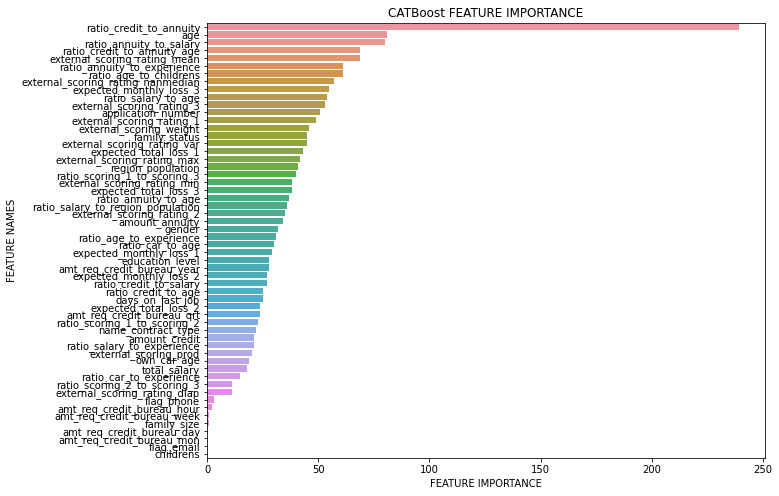

In [ ]:
top_features = plot_feature_importance(model_lgb.feature_importances_, x_valid.columns, 'CATBoost')

### Permutation importance

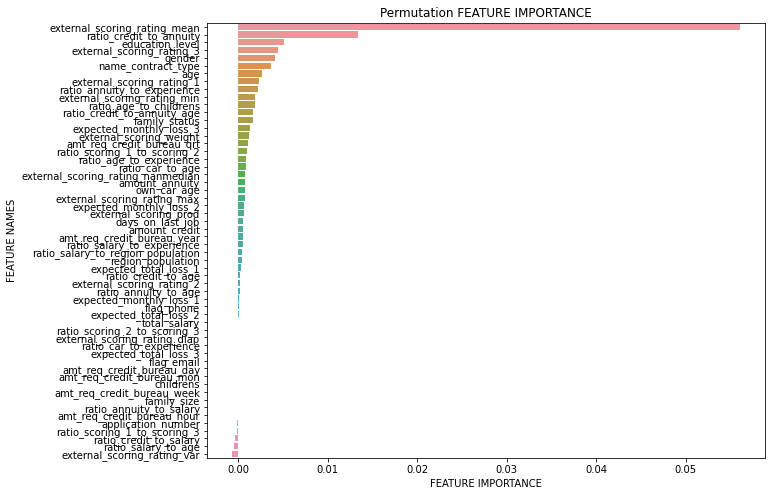

In [ ]:
importance = permutation_importance(model_lgb, x_valid, y_valid, scoring='roc_auc', n_jobs=6, random_state=27)
top_features = plot_feature_importance(importance['importances_mean'], x_valid.columns, 'Permutation')

In [ ]:
features_to_delete_permut = top_features[-30:]
features_to_delete_permut

['amount_credit',
 'amt_req_credit_bureau_year',
 'ratio_salary_to_experience',
 'ratio_salary_to_region_population',
 'region_population',
 'expected_total_loss_1',
 'ratio_credit_to_age',
 'external_scoring_rating_2',
 'ratio_annuity_to_age',
 'expected_monthly_loss_1',
 'flag_phone',
 'expected_total_loss_2',
 'total_salary',
 'ratio_scoring_2_to_scoring_3',
 'external_scoring_rating_diap',
 'ratio_car_to_experience',
 'expected_total_loss_3',
 'flag_email',
 'amt_req_credit_bureau_day',
 'amt_req_credit_bureau_mon',
 'childrens',
 'amt_req_credit_bureau_week',
 'family_size',
 'ratio_annuity_to_salary',
 'amt_req_credit_bureau_hour',
 'application_number',
 'ratio_scoring_1_to_scoring_3',
 'ratio_credit_to_salary',
 'ratio_salary_to_age',
 'external_scoring_rating_var']

### SHAP importance

In [ ]:
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(x_valid, y_valid)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [ ]:
#shap.initjs()
#shap.force_plot(explainer.expected_value, shap_values[0,:], x_valid.iloc[0,:])

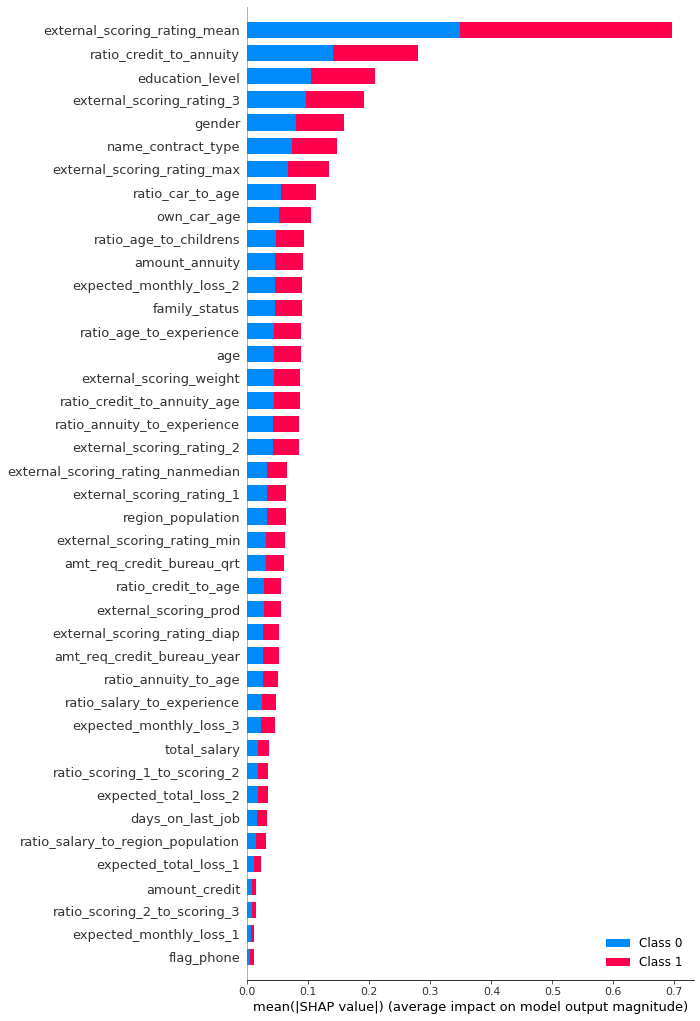

In [ ]:
# feature importance plot
shap.summary_plot(shap_values, x_valid, plot_type="bar", max_display=x_valid.shape[1])

In [ ]:
vals= np.abs(shap_values[0]).mean(0) 
feature_importance = pd.DataFrame(list(zip(x_valid.columns, vals)), columns=['col_name','feature_importance_vals']) 
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
feature_importance.head()

,col_name,feature_importance_vals
2,external_scoring_rating_mean,0.348390
35,ratio_credit_to_annuity,0.139855
10,education_level,0.104495
19,external_scoring_rating_3,0.095423
23,gender,0.079617


In [ ]:
features_to_delete_shap = feature_importance['col_name'].to_list()[-20:]

In [ ]:
features_to_delete_shap

['region_population',
 'external_scoring_rating_min',
 'amt_req_credit_bureau_qrt',
 'ratio_credit_to_age',
 'external_scoring_prod',
 'external_scoring_rating_diap',
 'amt_req_credit_bureau_year',
 'ratio_annuity_to_age',
 'ratio_salary_to_experience',
 'expected_monthly_loss_3',
 'total_salary',
 'ratio_scoring_1_to_scoring_2',
 'expected_total_loss_2',
 'days_on_last_job',
 'ratio_salary_to_region_population',
 'expected_total_loss_1',
 'amount_credit',
 'ratio_scoring_2_to_scoring_3',
 'expected_monthly_loss_1',
 'flag_phone']

In [ ]:
shap.summary_plot(shap_values, x_valid)

## Обучение модели на усеченном наборе признаков

In [ ]:
data = get_input("train.csv")
test = get_input("test.csv")
client_profile = get_input("client_profile.csv")
application_history = get_input("applications_history.csv")

client_profile = create_client_profile_features(client_profile)
data_ext = pd.merge(data, client_profile, how='left', on='application_number')

features_to_delete = set(features_to_delete_permut)
#features_to_delete = set(features_to_delete_shap)
columns_to_learn = list(set(data_ext.columns.to_list()) - features_to_delete)

data_ext = data_ext[columns_to_learn]

if 'application_number' in columns_to_learn:
  columns_to_learn.remove('application_number')

categorical_features = data_ext.select_dtypes(include=[np.object])
categorical_feature_names = categorical_features.columns.to_list()

for feature in categorical_feature_names:
    data_ext[feature] = pd.Series(data_ext[feature], dtype="category")

train_ext, valid_ext = train_test_split(
    data_ext, train_size=0.7, shuffle=True, random_state=1,
)

train_ext.reset_index(inplace=True, drop=True)
valid_ext.reset_index(inplace=True, drop=True)

y_train = train_ext['target']
x_train = train_ext.drop(columns=['target'])

y_valid = valid_ext['target']
x_valid = valid_ext.drop(columns=['target'])

dtrain = lgb.Dataset(
    data=x_train, label=y_train
)

dvalid = lgb.Dataset(
    data=x_valid, label=y_valid
)

lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "binary",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "num_boost_round ": 1000,
    "reg_lambda": 100,
    "max_depth": 3,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu'
}

cv_result_lgb_all_not_dummies = lgb.cv(
    params=lgbm_params,
    train_set=dtrain,
    num_boost_round=1000,
    categorical_feature=categorical_feature_names,
    early_stopping_rounds=100,
    verbose_eval=10,
    stratified=True,
    seed=42,
    metrics="auc",
    shuffle=True,
    nfold=7
)

train.csv: shape = 110093 rows, 3 cols
test.csv: shape = 165141 rows, 2 cols
client_profile.csv: shape = 250000 rows, 24 cols
applications_history.csv: shape = 1670214 rows, 26 cols


All-NaN slice encountered
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


[10]	cv_agg's auc: 0.698485 + 0.00641544
[20]	cv_agg's auc: 0.70396 + 0.00648819
[30]	cv_agg's auc: 0.711986 + 0.00731035
[40]	cv_agg's auc: 0.71567 + 0.00774247
[50]	cv_agg's auc: 0.718097 + 0.00745244
[60]	cv_agg's auc: 0.720116 + 0.00792152
[70]	cv_agg's auc: 0.721809 + 0.00761466
[80]	cv_agg's auc: 0.722859 + 0.00766872
[90]	cv_agg's auc: 0.723848 + 0.00767961
[100]	cv_agg's auc: 0.724792 + 0.0075045
[110]	cv_agg's auc: 0.72529 + 0.00739987
[120]	cv_agg's auc: 0.726078 + 0.00736898
[130]	cv_agg's auc: 0.726665 + 0.00751904
[140]	cv_agg's auc: 0.726993 + 0.00770983
[150]	cv_agg's auc: 0.727545 + 0.00761499
[160]	cv_agg's auc: 0.727814 + 0.00775046
[170]	cv_agg's auc: 0.728062 + 0.00759495
[180]	cv_agg's auc: 0.728287 + 0.0074838
[190]	cv_agg's auc: 0.728649 + 0.00727927
[200]	cv_agg's auc: 0.728959 + 0.00686586
[210]	cv_agg's auc: 0.729361 + 0.00704355
[220]	cv_agg's auc: 0.729709 + 0.00724005
[230]	cv_agg's auc: 0.729662 + 0.00706354
[240]	cv_agg's auc: 0.729567 + 0.00703097
[250]	

In [ ]:
cv = KFold(n_splits=7, random_state=435, shuffle=True)

lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "binary",
    #"eval_metric": "auc",
    "learning_rate": 0.1,
    "num_boost_round": 320,
    "reg_lambda": 100,
    "max_depth": 3,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu'
}

lgb_estimators, lgb_oof = lightgbm_cv_fit(
    lgbm_params, x_train, y_train, cv, categorical=categorical_feature_names
)

print(f"Out of fold ROC AUC { metrics.roc_auc_score(y_train, lgb_oof)}")

Sat Apr 24 07:21:07 2021, Cross-Validation, 77065 rows, 26 cols


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 1, Valid score = 0.72665


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 2, Valid score = 0.7126


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 3, Valid score = 0.73179


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 4, Valid score = 0.73078


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 5, Valid score = 0.71708


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 6, Valid score = 0.73337


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 7, Valid score = 0.7477
Score by each fold: [0.72665, 0.7126, 0.73179, 0.73078, 0.71708, 0.73337, 0.7477]
Out of fold ROC AUC 0.7275398217133645


In [ ]:
result = np.zeros((7, x_valid.shape[0]))
for i, estimator in enumerate(lgb_estimators):
  result[i] = estimator.predict_proba(x_valid)[:,1]

result_mean = np.mean(result, axis=0)
result_max = np.max(result, axis=0)
result_min = np.min(result, axis=0)

metrics.roc_auc_score(y_valid, result_mean)

0.7307574802097895

## Жадный отбор признаков

In [ ]:
def greedy_lgbm_selector(data: pd.DataFrame,
                         target: str,
                         lgb_params: dict) -> dict:
  """
  Жадный отбор признаков на основе lightgbm и последовательного исключения признаков из датасета.

  Parameters
  ----------
  data: pandas.core.frame.DataFrame
    Исходный датасет.
  
  target: str
    Название целевой переменной
  
  lgb_params: dict
    Параметры модели lightgbm

  Returns
  -------
  result: dict
    Значения качества модели при исключенных признаках.
  """

  result = {}

  train, valid = train_test_split(
    data, train_size=0.7, shuffle=True, random_state=1,
  )

  y_train = train[target]
  x_train = train.drop(columns=target)

  y_valid = valid[target]
  x_valid = valid.drop(columns=target)

  categorical_features = x_valid.select_dtypes(include=[np.object])
  categorical_feature_names = categorical_features.columns.to_list()
  del categorical_features
  for feature in categorical_feature_names:
    x_train[feature] = pd.Series(x_train[feature], dtype="category")
    x_valid[feature] = pd.Series(x_valid[feature], dtype="category")
  
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid)

  model_lgbm =  lgb.train(lgbm_params,
                lgb_train,
                valid_sets=lgb_eval,
                verbose_eval=False, 
                categorical_feature=categorical_feature_names,
                num_boost_round=10000,
                early_stopping_rounds=100)

  result['initial'] = model_lgbm.best_score['valid_0']['auc']
                       #'best iteration': model_lgbm.best_iteration_}
  
  print("="*50)
  print(f"Initial dataset: best score {model_lgbm.best_score['valid_0']['auc']}, best iteration {model_lgbm.best_iteration}")
  print("="*50)
  
  best_score = model_lgbm.best_score['valid_0']['auc']

  for i in range (len(x_train.columns.to_list())):
    feature_to_delete = None
    for feature in x_train.columns.to_list():
      #model_lgbm = lgb.LGBMClassifier(**lgb_params)
      new_cat_features = categorical_feature_names.copy()
      if feature in new_cat_features:
        new_cat_features.remove(feature)
      
      lgb_train = lgb.Dataset(x_train.drop(columns=feature), y_train)
      lgb_eval = lgb.Dataset(x_valid.drop(columns=feature), y_valid)

      model_lgbm =  lgb.train(lgbm_params,
                lgb_train,
                valid_sets=lgb_eval,
                verbose_eval=False, 
                categorical_feature=new_cat_features,
                num_boost_round=10000,
                early_stopping_rounds=100)
      
      if model_lgbm.best_score['valid_0']['auc'] > best_score:
        best_score = model_lgbm.best_score['valid_0']['auc']
        feature_to_delete = feature

      print(f"Dataset without {feature}: best score {model_lgbm.best_score['valid_0']['auc']}, best iteration {model_lgbm.best_iteration}")
    if feature_to_delete != None:
      result[f'without {feature_to_delete}'] = best_score
      x_train.drop(columns=feature_to_delete, inplace=True)
      x_valid.drop(columns=feature_to_delete, inplace=True)
      print("="*50)
      print(f"Dropped {feature_to_delete}, best score {best_score}")
      print("="*50)
    else:
      print("="*50)
      print("No features to delete to improve score")
      break
  return result

In [ ]:
data = get_input("train.csv")
client_profile = get_input("client_profile.csv")
client_profile = create_client_profile_features(client_profile)
data_ext = pd.merge(data, client_profile, how='left', on='application_number')
data_ext = data_ext[columns_to_learn]

lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "max_depth": 3,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu',
    'verbose': -1,
}

train.csv: shape = 110093 rows, 3 cols
client_profile.csv: shape = 250000 rows, 24 cols


All-NaN slice encountered


In [ ]:
result = greedy_lgbm_selector(data=data_ext, target='target', lgb_params=lgbm_params)

categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']
categorical_feature in param dict is overridden.


Initial dataset: best score 0.7300034321146216, best iteration 539
Dataset without external_scoring_rating_3: best score 0.7301368957858677, best iteration 419
Dataset without external_scoring_rating_nanmedian: best score 0.7303899871037762, best iteration 375


categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender']


Dataset without name_contract_type: best score 0.7298160512422445, best iteration 266


categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'name_contract_type']


Dataset without gender: best score 0.7273190969970083, best iteration 382
Dataset without amt_req_credit_bureau_qrt: best score 0.7296016690843428, best iteration 198


categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'gender', 'name_contract_type']


Dataset without family_status: best score 0.7289055200872002, best iteration 220
Dataset without ratio_scoring_1_to_scoring_2: best score 0.7303397895919338, best iteration 455
Dataset without age: best score 0.7306287667647006, best iteration 386
Dataset without amount_annuity: best score 0.7295969493474421, best iteration 401


categorical_feature in Dataset is overridden.
New categorical_feature is ['family_status', 'gender', 'name_contract_type']


Dataset without education_level: best score 0.7286087437626299, best iteration 492
Dataset without external_scoring_weight: best score 0.729951356464581, best iteration 313
Dataset without expected_monthly_loss_2: best score 0.7297929098965883, best iteration 431
Dataset without ratio_age_to_experience: best score 0.7298986405401545, best iteration 252
Dataset without own_car_age: best score 0.7309143779235538, best iteration 400
Dataset without ratio_annuity_to_experience: best score 0.7300806674990965, best iteration 472
Dataset without ratio_credit_to_annuity_age: best score 0.7299010979742255, best iteration 424
Dataset without ratio_credit_to_annuity: best score 0.7244608999433338, best iteration 351
Dataset without days_on_last_job: best score 0.7301311028271394, best iteration 396
Dataset without external_scoring_rating_1: best score 0.7295136100138231, best iteration 281
Dataset without ratio_age_to_childrens: best score 0.7304395260476791, best iteration 304
Dataset without ex

In [ ]:
result

{'initial': 0.7300034321146216,
 'without expected_monthly_loss_2': 0.7329432976906608,
 'without external_scoring_rating_1': 0.7337646965533579,
 'without external_scoring_rating_max': 0.7318393487904595,
 'without own_car_age': 0.7309143779235538,
 'without ratio_annuity_to_experience': 0.7326514972127454}

## Проверка

In [ ]:
features_to_delete_greedy_1 = set(['age', 'amt_req_credit_bureau_year', 'own_car_age', 'region_population'
                                 'expected_monthly_loss_2', 'expected_total_loss_1', 'external_scoring_rating_max'])

features_to_delete_permut_1 = ['ratio_credit_to_age',
 'ratio_annuity_to_age',
 'external_scoring_rating_2',
 'flag_phone',
 'external_scoring_rating_diap',
 'expected_monthly_loss_1',
 'total_salary',
 'ratio_scoring_2_to_scoring_3',
 'ratio_annuity_to_salary',
 'expected_total_loss_3',
 'ratio_car_to_experience',
 'application_number',
 'amt_req_credit_bureau_week',
 'amt_req_credit_bureau_mon',
 'amt_req_credit_bureau_day',
 'flag_email',
 'childrens',
 'family_size',
 'ratio_scoring_1_to_scoring_3',
 'amt_req_credit_bureau_hour',
 'expected_total_loss_2',
 'ratio_credit_to_salary',
 'ratio_salary_to_age',
 'external_scoring_rating_var']

features_to_delete_greedy_2 = set(['without expected_monthly_loss_2',
 'without external_scoring_rating_1',
 'without external_scoring_rating_max',
 'without own_car_age',
 'without ratio_annuity_to_experience'])

features_to_delete_permut_2 = ['amount_credit',
 'amt_req_credit_bureau_year',
 'ratio_salary_to_experience',
 'ratio_salary_to_region_population',
 'region_population',
 'expected_total_loss_1',
 'ratio_credit_to_age',
 'external_scoring_rating_2',
 'ratio_annuity_to_age',
 'expected_monthly_loss_1',
 'flag_phone',
 'expected_total_loss_2',
 'total_salary',
 'ratio_scoring_2_to_scoring_3',
 'external_scoring_rating_diap',
 'ratio_car_to_experience',
 'expected_total_loss_3',
 'flag_email',
 'amt_req_credit_bureau_day',
 'amt_req_credit_bureau_mon',
 'childrens',
 'amt_req_credit_bureau_week',
 'family_size',
 'ratio_annuity_to_salary',
 'amt_req_credit_bureau_hour',
 'application_number',
 'ratio_scoring_1_to_scoring_3',
 'ratio_credit_to_salary',
 'ratio_salary_to_age',
 'external_scoring_rating_var']

In [ ]:
data = get_input("train.csv")
test = get_input("test.csv")
client_profile = get_input("client_profile.csv")
application_history = get_input("applications_history.csv")

client_profile = create_client_profile_features(client_profile)
data_ext = pd.merge(data, client_profile, how='left', on='application_number')

features_to_delete = set(features_to_delete_permut_1)
#features_to_delete_greedy = set(['age', 'amt_req_credit_bureau_year', 'own_car_age', 'region_population'
#                                 'expected_monthly_loss_2', 'expected_total_loss_1', 'external_scoring_rating_max'])
columns_to_learn = list(set(data_ext.columns.to_list()) - features_to_delete - features_to_delete_greedy_1)

data_ext = data_ext[columns_to_learn]

if 'application_number' in columns_to_learn:
  columns_to_learn.remove('application_number')

categorical_features = data_ext.select_dtypes(include=[np.object])
categorical_feature_names = categorical_features.columns.to_list()

for feature in categorical_feature_names:
    data_ext[feature] = pd.Series(data_ext[feature], dtype="category")

train_ext, valid_ext = train_test_split(
    data_ext, train_size=0.7, shuffle=True, random_state=1,
)

train_ext.reset_index(inplace=True, drop=True)
valid_ext.reset_index(inplace=True, drop=True)

y_train = train_ext['target']
x_train = train_ext.drop(columns=['target'])

y_valid = valid_ext['target']
x_valid = valid_ext.drop(columns=['target'])

dtrain = lgb.Dataset(
    data=x_train, label=y_train
)

dvalid = lgb.Dataset(
    data=x_valid, label=y_valid
)

lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "binary",
    "eval_metric": "auc",
    "learning_rate": 0.09,
    "num_leaves": 54,
    "num_boost_round ": 1000,
    "reg_lambda": 100,
    "max_depth": 3,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu'
}

cv_result = lgb.cv(
    params=lgbm_params,
    train_set=dtrain,
    num_boost_round=1000,
    categorical_feature=categorical_feature_names,
    early_stopping_rounds=100,
    verbose_eval=10,
    stratified=True,
    seed=42,
    metrics="auc",
    shuffle=True,
    nfold=7
)

train.csv: shape = 110093 rows, 3 cols
test.csv: shape = 165141 rows, 2 cols
client_profile.csv: shape = 250000 rows, 24 cols
applications_history.csv: shape = 1670214 rows, 26 cols


All-NaN slice encountered
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


[10]	cv_agg's auc: 0.697565 + 0.00706954
[20]	cv_agg's auc: 0.702744 + 0.00701803
[30]	cv_agg's auc: 0.709574 + 0.00767333
[40]	cv_agg's auc: 0.714199 + 0.00732967
[50]	cv_agg's auc: 0.717358 + 0.00742645
[60]	cv_agg's auc: 0.719226 + 0.00756772
[70]	cv_agg's auc: 0.720985 + 0.00823143
[80]	cv_agg's auc: 0.722467 + 0.00812132
[90]	cv_agg's auc: 0.723614 + 0.00804393
[100]	cv_agg's auc: 0.723937 + 0.00774385
[110]	cv_agg's auc: 0.724317 + 0.00763973
[120]	cv_agg's auc: 0.724827 + 0.0075906
[130]	cv_agg's auc: 0.725363 + 0.00754638
[140]	cv_agg's auc: 0.725809 + 0.00735398
[150]	cv_agg's auc: 0.726059 + 0.00743441
[160]	cv_agg's auc: 0.726591 + 0.00719781
[170]	cv_agg's auc: 0.726874 + 0.00717217
[180]	cv_agg's auc: 0.727253 + 0.00682602
[190]	cv_agg's auc: 0.727741 + 0.00656091
[200]	cv_agg's auc: 0.727818 + 0.00655677
[210]	cv_agg's auc: 0.728023 + 0.00661292
[220]	cv_agg's auc: 0.728485 + 0.006392
[230]	cv_agg's auc: 0.728695 + 0.00647459
[240]	cv_agg's auc: 0.728959 + 0.00640251
[250

In [ ]:
cv = KFold(n_splits=7, random_state=435, shuffle=True)

lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "binary",
    #"eval_metric": "auc",
    "learning_rate": 0.09,
    "num_boost_round": 410,
    "num_leaves": 54,
    "reg_lambda": 100,
    "max_depth": 3,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu'
}

lgb_estimators, lgb_oof = lightgbm_cv_fit(
    lgbm_params, x_train, y_train, cv, categorical=categorical_feature_names
)

print(f"Out of fold ROC AUC { metrics.roc_auc_score(y_train, lgb_oof)}")

Sat Apr 24 07:50:25 2021, Cross-Validation, 77065 rows, 27 cols


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 1, Valid score = 0.7284


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 2, Valid score = 0.70878


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 3, Valid score = 0.73269


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 4, Valid score = 0.73075


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 5, Valid score = 0.71756


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 6, Valid score = 0.73322


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 7, Valid score = 0.75028
Score by each fold: [0.7284, 0.70878, 0.73269, 0.73075, 0.71756, 0.73322, 0.75028]
Out of fold ROC AUC 0.7276500082376741


In [ ]:
result_1 = np.zeros((7, x_valid.shape[0]))
for i, estimator in enumerate(lgb_estimators):
  result_1[i] = estimator.predict_proba(x_valid)[:,1]

result_mean_1 = np.mean(result_1, axis=0)
result_max_1 = np.max(result_1, axis=0)
result_min_1 = np.min(result_1, axis=0)

metrics.roc_auc_score(y_valid, result_mean_1)

0.7303769864848201

In [ ]:
result_2 = np.zeros((7, x_valid.shape[0]))
for i, estimator in enumerate(lgb_estimators):
  result_2[i] = estimator.predict_proba(x_valid)[:,1]

result_mean_2 = np.mean(result_2, axis=0)
result_max_2 = np.max(result_2, axis=0)
result_min_2 = np.min(result_2, axis=0)

metrics.roc_auc_score(y_valid, result_mean_2)

0.7305423602118813

In [ ]:
result_all = (result_mean_1 * result_mean_2)**(1/2)

In [ ]:
result_all = (result_mean_1 + result_mean_2)/2

In [ ]:
metrics.roc_auc_score(y_valid, result_all)

0.730790372019663

## Получение результатов для Test

In [ ]:
data = get_input("train.csv")
test = get_input("test.csv")
client_profile = get_input("client_profile.csv")

client_profile = create_client_profile_features(client_profile)
data_ext = pd.merge(data, client_profile, how='left', on='application_number')
test_ext = pd.merge(test, client_profile, how='left', on='application_number')

features_to_delete = set(features_to_delete_permut_1)
#features_to_delete_greedy = set(['age', 'amt_req_credit_bureau_year', 'own_car_age', 'region_population'
#                                 'expected_monthly_loss_2', 'expected_total_loss_1', 'external_scoring_rating_max'])
columns_to_learn = list(set(data_ext.columns.to_list()) - features_to_delete - features_to_delete_greedy_1)

data_ext = data_ext[columns_to_learn]
columns_to_learn_without_target = columns_to_learn.copy()
columns_to_learn_without_target.remove('target')
test_ext = test_ext[columns_to_learn_without_target]

if 'application_number' in columns_to_learn:
  columns_to_learn.remove('application_number')

categorical_features = data_ext.select_dtypes(include=[np.object])
categorical_feature_names = categorical_features.columns.to_list()

for feature in categorical_feature_names:
    data_ext[feature] = pd.Series(data_ext[feature], dtype="category")

y_train = data_ext['target']
x_train = data_ext.drop(columns=['target'])

dtrain = lgb.Dataset(
    data=x_train, label=y_train
)

lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "binary",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "num_boost_round ": 1000,
    "reg_lambda": 100,
    "max_depth": 3,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu'
}

cv_result = lgb.cv(
    params=lgbm_params,
    train_set=dtrain,
    num_boost_round=1000,
    categorical_feature=categorical_feature_names,
    early_stopping_rounds=100,
    verbose_eval=10,
    stratified=True,
    seed=42,
    metrics="auc",
    shuffle=True,
    nfold=7
)

train.csv: shape = 110093 rows, 3 cols
test.csv: shape = 165141 rows, 2 cols
client_profile.csv: shape = 250000 rows, 24 cols


All-NaN slice encountered
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


[10]	cv_agg's auc: 0.699984 + 0.00622522
[20]	cv_agg's auc: 0.704937 + 0.00592437
[30]	cv_agg's auc: 0.712831 + 0.00584046
[40]	cv_agg's auc: 0.71681 + 0.00555256
[50]	cv_agg's auc: 0.719415 + 0.00547527
[60]	cv_agg's auc: 0.720781 + 0.00553722
[70]	cv_agg's auc: 0.721951 + 0.00519979
[80]	cv_agg's auc: 0.722896 + 0.00560114
[90]	cv_agg's auc: 0.723585 + 0.00596014
[100]	cv_agg's auc: 0.724333 + 0.00583867
[110]	cv_agg's auc: 0.725195 + 0.0060853
[120]	cv_agg's auc: 0.72552 + 0.00616952
[130]	cv_agg's auc: 0.726181 + 0.00617404
[140]	cv_agg's auc: 0.726584 + 0.0060145
[150]	cv_agg's auc: 0.727255 + 0.00580133
[160]	cv_agg's auc: 0.727524 + 0.00578339
[170]	cv_agg's auc: 0.727845 + 0.00593584
[180]	cv_agg's auc: 0.728131 + 0.00595243
[190]	cv_agg's auc: 0.728378 + 0.00586331
[200]	cv_agg's auc: 0.728706 + 0.006047
[210]	cv_agg's auc: 0.728798 + 0.0061863
[220]	cv_agg's auc: 0.728886 + 0.00601161
[230]	cv_agg's auc: 0.729151 + 0.00606137
[240]	cv_agg's auc: 0.729316 + 0.00604711
[250]	cv

In [ ]:
cv = KFold(n_splits=7, random_state=435, shuffle=True)

lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "binary",
    #"eval_metric": "auc",
    "learning_rate": 0.1,
    "num_boost_round": 530,
    "reg_lambda": 100,
    "max_depth": 3,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu'
}

lgb_estimators_1, lgb_oof = lightgbm_cv_fit(
    lgbm_params, x_train, y_train, cv, categorical=categorical_feature_names
)

print(f"Out of fold ROC AUC { metrics.roc_auc_score(y_train, lgb_oof)}")

Sat Apr 24 08:29:00 2021, Cross-Validation, 110093 rows, 27 cols


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 1, Valid score = 0.74632


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 2, Valid score = 0.74376


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 3, Valid score = 0.73723


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 4, Valid score = 0.71375


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 5, Valid score = 0.72999


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 6, Valid score = 0.71839


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 7, Valid score = 0.72789
Score by each fold: [0.74632, 0.74376, 0.73723, 0.71375, 0.72999, 0.71839, 0.72789]
Out of fold ROC AUC 0.7306420010426008


In [ ]:
for feature in categorical_feature_names:
    test_ext[feature] = pd.Series(test_ext[feature], dtype="category")

In [ ]:
result_1 = np.zeros((7, test_ext.shape[0]))
for i, estimator in enumerate(lgb_estimators_1):
  result_1[i] = estimator.predict_proba(test_ext)[:,1]

result_1_mean = np.mean(result_1, axis=0)
result_1_max = np.max(result_1, axis=0)
result_1_min = np.min(result_1, axis=0)

In [ ]:
data = get_input("train.csv")
test = get_input("test.csv")
client_profile = get_input("client_profile.csv")

client_profile = create_client_profile_features(client_profile)
data_ext = pd.merge(data, client_profile, how='left', on='application_number')
test_ext = pd.merge(test, client_profile, how='left', on='application_number')

features_to_delete = set(features_to_delete_permut_2)
#features_to_delete_greedy = set(['age', 'amt_req_credit_bureau_year', 'own_car_age', 'region_population'
#                                 'expected_monthly_loss_2', 'expected_total_loss_1', 'external_scoring_rating_max'])
columns_to_learn = list(set(data_ext.columns.to_list()) - features_to_delete - features_to_delete_greedy_2)

data_ext = data_ext[columns_to_learn]
columns_to_learn_without_target = columns_to_learn.copy()
columns_to_learn_without_target.remove('target')
test_ext = test_ext[columns_to_learn_without_target]

if 'application_number' in columns_to_learn:
  columns_to_learn.remove('application_number')

categorical_features = data_ext.select_dtypes(include=[np.object])
categorical_feature_names = categorical_features.columns.to_list()

for feature in categorical_feature_names:
    data_ext[feature] = pd.Series(data_ext[feature], dtype="category")

y_train = data_ext['target']
x_train = data_ext.drop(columns=['target'])

dtrain = lgb.Dataset(
    data=x_train, label=y_train
)

lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "binary",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "num_boost_round ": 1000,
    "reg_lambda": 100,
    "max_depth": 3,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu'
}

cv_result = lgb.cv(
    params=lgbm_params,
    train_set=dtrain,
    num_boost_round=1000,
    categorical_feature=categorical_feature_names,
    early_stopping_rounds=100,
    verbose_eval=10,
    stratified=True,
    seed=42,
    metrics="auc",
    shuffle=True,
    nfold=7
)

train.csv: shape = 110093 rows, 3 cols
test.csv: shape = 165141 rows, 2 cols
client_profile.csv: shape = 250000 rows, 24 cols


All-NaN slice encountered
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


[10]	cv_agg's auc: 0.700381 + 0.00552249
[20]	cv_agg's auc: 0.705787 + 0.00580199
[30]	cv_agg's auc: 0.713272 + 0.00568633
[40]	cv_agg's auc: 0.717427 + 0.00594248
[50]	cv_agg's auc: 0.719978 + 0.00562365
[60]	cv_agg's auc: 0.721616 + 0.00526249
[70]	cv_agg's auc: 0.72274 + 0.00537578
[80]	cv_agg's auc: 0.723697 + 0.00538306
[90]	cv_agg's auc: 0.724592 + 0.0053374
[100]	cv_agg's auc: 0.725343 + 0.00521104
[110]	cv_agg's auc: 0.726046 + 0.00550107
[120]	cv_agg's auc: 0.726511 + 0.00555756
[130]	cv_agg's auc: 0.726915 + 0.00539271
[140]	cv_agg's auc: 0.727405 + 0.00554418
[150]	cv_agg's auc: 0.727808 + 0.00564702
[160]	cv_agg's auc: 0.728371 + 0.0056461
[170]	cv_agg's auc: 0.728851 + 0.00562953
[180]	cv_agg's auc: 0.729245 + 0.00563252
[190]	cv_agg's auc: 0.729391 + 0.0058752
[200]	cv_agg's auc: 0.729488 + 0.00602569
[210]	cv_agg's auc: 0.729634 + 0.00585263
[220]	cv_agg's auc: 0.729667 + 0.00577774
[230]	cv_agg's auc: 0.72998 + 0.00560577
[240]	cv_agg's auc: 0.729874 + 0.00567577
[250]	

In [ ]:
cv = KFold(n_splits=7, random_state=435, shuffle=True)

lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "binary",
    #"eval_metric": "auc",
    "learning_rate": 0.1,
    "num_boost_round": 400,
    "reg_lambda": 100,
    "max_depth": 3,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu'
}

lgb_estimators_2, lgb_oof = lightgbm_cv_fit(
    lgbm_params, x_train, y_train, cv, categorical=categorical_feature_names
)

print(f"Out of fold ROC AUC { metrics.roc_auc_score(y_train, lgb_oof)}")

Sat Apr 24 08:31:21 2021, Cross-Validation, 110093 rows, 26 cols


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 1, Valid score = 0.74476


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 2, Valid score = 0.74365


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 3, Valid score = 0.73689


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 4, Valid score = 0.71428


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 5, Valid score = 0.73078


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 6, Valid score = 0.71896


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['education_level', 'family_status', 'gender', 'name_contract_type']


Fold 7, Valid score = 0.72854
Score by each fold: [0.74476, 0.74365, 0.73689, 0.71428, 0.73078, 0.71896, 0.72854]
Out of fold ROC AUC 0.7306634662474903


In [ ]:
for feature in categorical_feature_names:
    test_ext[feature] = pd.Series(test_ext[feature], dtype="category")

In [ ]:
result_2 = np.zeros((7, test_ext.shape[0]))
for i, estimator in enumerate(lgb_estimators_2):
  result_2[i] = estimator.predict_proba(test_ext)[:,1]

result_2_mean = np.mean(result_2, axis=0)
result_2_max = np.max(result_2, axis=0)
result_2_min = np.min(result_2, axis=0)

In [ ]:
test['TARGET'] = (result_1_mean * result_2_mean) ** (0.5)
test.drop(columns=['name_contract_type']).to_csv('result.csv', index=False)

## Простой пример lightgbm

In [ ]:
data = get_input("train.csv")
client_profile = get_input("client_profile.csv")
client_profile = create_client_profile_features(client_profile)
data_ext = pd.merge(data, client_profile, how='left', on='application_number')
data_ext = data_ext[columns_to_learn[:15]]

train, valid = train_test_split(
  data_ext, train_size=0.7, shuffle=True, random_state=1,
)

y_train = train['target']
x_train = train.drop(columns='target')

y_valid = valid['target']
x_valid = valid.drop(columns='target')

categorical_features = x_valid.select_dtypes(include=[np.object])
categorical_feature_names = categorical_features.columns.to_list()

for feature in categorical_feature_names:
  x_train[feature] = pd.Series(x_train[feature], dtype="category")
  x_valid[feature] = pd.Series(x_valid[feature], dtype="category")

lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "max_depth": 3,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu',
    'verbose': -1,
}

lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_valid, y_valid)

gbm = lgb.train(lgbm_params,
                lgb_train,
                valid_sets=lgb_eval,
                verbose_eval=False, 
                categorical_feature=categorical_feature_names,
                num_boost_round=10000,
                early_stopping_rounds=100)

gbm.best_iteration
gbm.best_score['valid_0']['auc']

var 1